In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans, HDBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy import stats

In [22]:
df_scaled = pd.read_parquet('output/dataset_estandarizado_para_clustering.parquet')
print(f"\nDataset cargado: {df_scaled.shape[0]:,} hogares × {df_scaled.shape[1]} variables")



Dataset cargado: 57,366 hogares × 168 variables


In [23]:
# Verificaciones
print(f"\nVerificaciones:")
print(f"   Faltantes: {df_scaled.isnull().sum().sum()}")
print(f"   Infinitos: {np.isinf(df_scaled.values).sum()}")
print(f"   Media global: {df_scaled.mean().mean():.6f}")

# Convertir a array para clustering
X = df_scaled.values

print(f"\nArray preparado para clustering: {X.shape}")


Verificaciones:
   Faltantes: 0
   Infinitos: 0
   Media global: 0.614745

Array preparado para clustering: (57366, 168)


In [24]:
print("\n" + "-"*80)
print("K-MEANS: BÚSQUEDA DEL K ÓPTIMO")
print("-"*80)


# Rango de k a probar
k_range = range(2, 16)

# Almacenar resultados
kmeans_results = []

print(f"\nEjecutando K-means para k={min(k_range)} a k={max(k_range)}...")
print("   (Esto puede tardar varios minutos)")

for k in k_range:
    print(f"\n   Ejecutando k={k}...", end=" ")
    
    # K-means
    kmeans = KMeans(
        n_clusters=k,
        init='k-means++',
        n_init=10,
        max_iter=300,
        random_state=42
    )
    
    # Fit
    labels = kmeans.fit_predict(X)
    
    # Calcular métricas
    inertia = kmeans.inertia_
    silhouette = silhouette_score(X, labels, sample_size=10000)  # Sample para velocidad
    davies_bouldin = davies_bouldin_score(X, labels)
    calinski_harabasz = calinski_harabasz_score(X, labels)
    
    # Tamaños de clusters
    cluster_sizes = pd.Series(labels).value_counts().sort_index()
    min_cluster_size = cluster_sizes.min()
    max_cluster_size = cluster_sizes.max()
    
    # Guardar resultados
    kmeans_results.append({
        'k': k,
        'inertia': inertia,
        'silhouette': silhouette,
        'davies_bouldin': davies_bouldin,
        'calinski_harabasz': calinski_harabasz,
        'min_cluster_size': min_cluster_size,
        'max_cluster_size': max_cluster_size,
        'labels': labels,
        'model': kmeans
    })
    
    print(f"Silhouette={silhouette:.4f}")

df_kmeans = pd.DataFrame(kmeans_results)

print(f"\nK-means completado para {len(k_range)} valores de k")


--------------------------------------------------------------------------------
K-MEANS: BÚSQUEDA DEL K ÓPTIMO
--------------------------------------------------------------------------------

Ejecutando K-means para k=2 a k=15...
   (Esto puede tardar varios minutos)

   Ejecutando k=2... Silhouette=0.7830

   Ejecutando k=3... Silhouette=0.6989

   Ejecutando k=4... Silhouette=0.7244

   Ejecutando k=5... Silhouette=0.7369

   Ejecutando k=6... Silhouette=0.6310

   Ejecutando k=7... Silhouette=0.6350

   Ejecutando k=8... Silhouette=0.6463

   Ejecutando k=9... Silhouette=0.6445

   Ejecutando k=10... Silhouette=0.5865

   Ejecutando k=11... Silhouette=0.5853

   Ejecutando k=12... Silhouette=0.5892

   Ejecutando k=13... Silhouette=0.5887

   Ejecutando k=14... Silhouette=0.5823

   Ejecutando k=15... Silhouette=0.5446

K-means completado para 14 valores de k



VISUALIZACIÓN: SELECCIÓN DE K ÓPTIMO

Gráfico guardado: kmeans_metricas.png


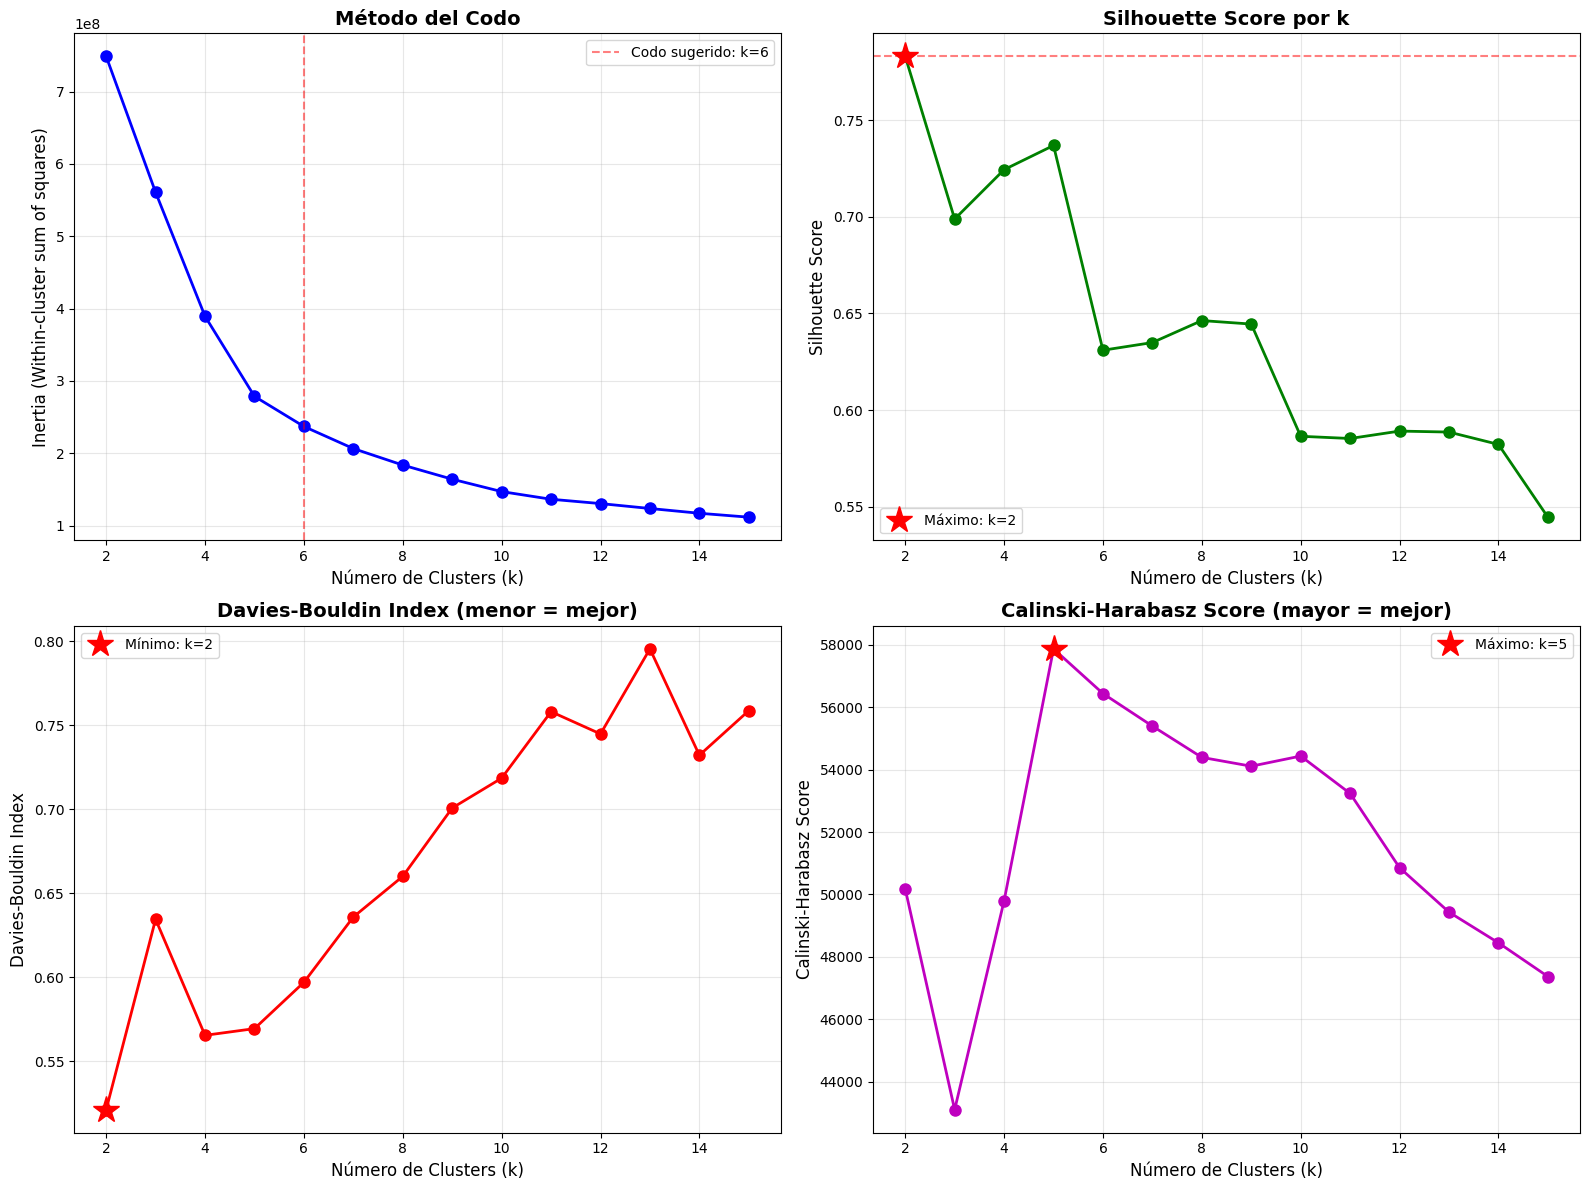

In [25]:
print("\n" + "="*80)
print("VISUALIZACIÓN: SELECCIÓN DE K ÓPTIMO")
print("="*80)

# Crear figura con 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Método del codo (Inertia)
ax1 = axes[0, 0]
ax1.plot(df_kmeans['k'], df_kmeans['inertia'], 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Número de Clusters (k)', fontsize=12)
ax1.set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
ax1.set_title('Método del Codo', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Marcar el codo sugerido (heurística: donde la reducción es < 10% del anterior)
inertias = df_kmeans['inertia'].values
for i in range(1, len(inertias)-1):
    reduccion = (inertias[i-1] - inertias[i]) / inertias[i-1]
    if reduccion < 0.2:  # Menos del 10% de mejora
        ax1.axvline(x=i+2, color='red', linestyle='--', alpha=0.5, label=f'Codo sugerido: k={i+2}')
        break

ax1.legend()

# 2. Silhouette Score
ax2 = axes[0, 1]
ax2.plot(df_kmeans['k'], df_kmeans['silhouette'], 'go-', linewidth=2, markersize=8)
ax2.set_xlabel('Número de Clusters (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Silhouette Score por k', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=df_kmeans['silhouette'].max(), color='red', linestyle='--', alpha=0.5)

# Marcar el máximo
max_silhouette_idx = df_kmeans['silhouette'].idxmax()
max_silhouette_k = df_kmeans.loc[max_silhouette_idx, 'k']
ax2.plot(max_silhouette_k, df_kmeans['silhouette'].max(), 'r*', markersize=20, 
         label=f'Máximo: k={max_silhouette_k}')
ax2.legend()

# 3. Davies-Bouldin Index (menor es mejor)
ax3 = axes[1, 0]
ax3.plot(df_kmeans['k'], df_kmeans['davies_bouldin'], 'ro-', linewidth=2, markersize=8)
ax3.set_xlabel('Número de Clusters (k)', fontsize=12)
ax3.set_ylabel('Davies-Bouldin Index', fontsize=12)
ax3.set_title('Davies-Bouldin Index (menor = mejor)', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Marcar el mínimo
min_db_idx = df_kmeans['davies_bouldin'].idxmin()
min_db_k = df_kmeans.loc[min_db_idx, 'k']
ax3.plot(min_db_k, df_kmeans['davies_bouldin'].min(), 'r*', markersize=20,
         label=f'Mínimo: k={min_db_k}')
ax3.legend()

# 4. Calinski-Harabasz Score (mayor es mejor)
ax4 = axes[1, 1]
ax4.plot(df_kmeans['k'], df_kmeans['calinski_harabasz'], 'mo-', linewidth=2, markersize=8)
ax4.set_xlabel('Número de Clusters (k)', fontsize=12)
ax4.set_ylabel('Calinski-Harabasz Score', fontsize=12)
ax4.set_title('Calinski-Harabasz Score (mayor = mejor)', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)

# Marcar el máximo
max_ch_idx = df_kmeans['calinski_harabasz'].idxmax()
max_ch_k = df_kmeans.loc[max_ch_idx, 'k']
ax4.plot(max_ch_k, df_kmeans['calinski_harabasz'].max(), 'r*', markersize=20,
         label=f'Máximo: k={max_ch_k}')
ax4.legend()

plt.tight_layout()
plt.savefig('images/kmeans_metricas.png', dpi=150, bbox_inches='tight')
print(f"\nGráfico guardado: kmeans_metricas.png")
plt.show()

In [26]:
print("\n" + "-"*80)
print("TABLA DE MÉTRICAS POR K")
print("-"*80)

# Crear tabla resumen
tabla_metricas = df_kmeans[['k', 'inertia', 'silhouette', 'davies_bouldin', 
                             'calinski_harabasz', 'min_cluster_size', 'max_cluster_size']].copy()

# Normalizar métricas para comparación
tabla_metricas['silhouette_norm'] = (tabla_metricas['silhouette'] - tabla_metricas['silhouette'].min()) / \
                                     (tabla_metricas['silhouette'].max() - tabla_metricas['silhouette'].min())

tabla_metricas['davies_bouldin_norm'] = 1 - ((tabla_metricas['davies_bouldin'] - tabla_metricas['davies_bouldin'].min()) / \
                                              (tabla_metricas['davies_bouldin'].max() - tabla_metricas['davies_bouldin'].min()))

tabla_metricas['calinski_harabasz_norm'] = (tabla_metricas['calinski_harabasz'] - tabla_metricas['calinski_harabasz'].min()) / \
                                            (tabla_metricas['calinski_harabasz'].max() - tabla_metricas['calinski_harabasz'].min())

# Score compuesto (promedio de métricas normalizadas)
tabla_metricas['score_compuesto'] = (tabla_metricas['silhouette_norm'] + 
                                     tabla_metricas['davies_bouldin_norm'] + 
                                     tabla_metricas['calinski_harabasz_norm']) / 3

print("\nMétricas por k:\n")
display(tabla_metricas.round(4))

# Identificar mejores k según diferentes criterios
print("\nRECOMENDACIONES POR MÉTRICA:")
print("-"*80)
print(f"   Mejor Silhouette:         k = {tabla_metricas.loc[tabla_metricas['silhouette'].idxmax(), 'k']:.0f} (score = {tabla_metricas['silhouette'].max():.4f})")
print(f"   Mejor Davies-Bouldin:     k = {tabla_metricas.loc[tabla_metricas['davies_bouldin'].idxmin(), 'k']:.0f} (score = {tabla_metricas['davies_bouldin'].min():.4f})")
print(f"   Mejor Calinski-Harabasz:  k = {tabla_metricas.loc[tabla_metricas['calinski_harabasz'].idxmax(), 'k']:.0f} (score = {tabla_metricas['calinski_harabasz'].max():.0f})")
print(f"   Mejor Score Compuesto:    k = {tabla_metricas.loc[tabla_metricas['score_compuesto'].idxmax(), 'k']:.0f} (score = {tabla_metricas['score_compuesto'].max():.4f})")

k_recomendado = int(tabla_metricas.loc[tabla_metricas['score_compuesto'].idxmax(), 'k'])
print(f"\nK RECOMENDADO (score compuesto): {k_recomendado}")



--------------------------------------------------------------------------------
TABLA DE MÉTRICAS POR K
--------------------------------------------------------------------------------

Métricas por k:



,k,inertia,silhouette,davies_bouldin,calinski_harabasz,min_cluster_size,max_cluster_size,silhouette_norm,davies_bouldin_norm,calinski_harabasz_norm,score_compuesto
0,2,7.486536e+08,0.7830,0.5211,50178.8857,2766,54600,1.0000,1.0000,0.4791,0.8264
1,3,5.607861e+08,0.6989,0.6344,43102.5289,2711,51924,0.6470,0.5868,0.0000,0.4113
2,4,3.894001e+08,0.7244,0.5653,49796.9455,1859,50193,0.7541,0.8386,0.4533,0.6820
3,5,2.787235e+08,0.7369,0.5693,57871.2322,1287,48641,0.8066,0.8241,1.0000,0.8769
4,6,2.370922e+08,0.6310,0.5969,56439.7617,1287,46306,0.3623,0.7236,0.9031,0.6630
5,7,2.065624e+08,0.6350,0.6358,55396.6153,959,45651,0.3790,0.5819,0.8324,0.5978
6,8,1.837502e+08,0.6463,0.6599,54394.0332,787,44527,0.4267,0.4937,0.7646,0.5616
7,9,1.642101e+08,0.6445,0.7006,54110.5027,959,43585,0.4191,0.3453,0.7454,0.5033
8,10,1.470931e+08,0.5865,0.7184,54436.0072,947,41604,0.1756,0.2806,0.7674,0.4078
9,11,1.365030e+08,0.5853,0.7580,53237.3794,734,41280,0.1708,0.1363,0.6862,0.3311



RECOMENDACIONES POR MÉTRICA:
--------------------------------------------------------------------------------
   Mejor Silhouette:         k = 2 (score = 0.7830)
   Mejor Davies-Bouldin:     k = 2 (score = 0.5211)
   Mejor Calinski-Harabasz:  k = 5 (score = 57871)
   Mejor Score Compuesto:    k = 5 (score = 0.8769)

K RECOMENDADO (score compuesto): 5


In [27]:
print("\n" + "-"*80)
print("HDBSCAN: CLUSTERING BASADO EN DENSIDAD")
print("-"*80)

print(f"\nEjecutando HDBSCAN...")
print("   (Esto puede tardar varios minutos para dataset grande)")


print(f"\nTotal de datos: {len(X):,}")

# 2. Configurar HDBSCAN (ajustado para Scikit-Learn)
hdbscan_clusterer = HDBSCAN(
    min_cluster_size=int(len(X) * 0.01),  # 1% del dataset como mínimo
    min_samples=10,
    metric='euclidean',
    cluster_selection_method='eom',
    n_jobs=-1  # <--- En sklearn se llama 'n_jobs', no 'core_dist_n_jobs'
)


# Fit
hdbscan_labels = hdbscan_clusterer.fit_predict(X)

# Analizar resultados
n_clusters_hdbscan = len(set(hdbscan_labels)) - (1 if -1 in hdbscan_labels else 0)
n_noise = list(hdbscan_labels).count(-1)

print(f"\nHDBSCAN completado:")
print(f"   Clusters detectados: {n_clusters_hdbscan}")
print(f"   Outliers (ruido): {n_noise:,} ({n_noise/len(X)*100:.2f}%)")

# Tamaños de clusters
cluster_sizes_hdbscan = pd.Series(hdbscan_labels).value_counts().sort_index()
print(f"\nDistribución de clusters HDBSCAN:")
for cluster_id, size in cluster_sizes_hdbscan.items():
    if cluster_id == -1:
        print(f"   Outliers:   {size:6,} hogares ({size/len(X)*100:5.2f}%)")
    else:
        print(f"   Cluster {cluster_id}: {size:6,} hogares ({size/len(X)*100:5.2f}%)")

# Calcular métricas para HDBSCAN (excluyendo outliers)
if n_clusters_hdbscan > 1:
    # Filtrar outliers para métricas
    mask_no_noise = hdbscan_labels != -1
    X_no_noise = X[mask_no_noise]
    labels_no_noise = hdbscan_labels[mask_no_noise]
    
    silhouette_hdbscan = silhouette_score(X_no_noise, labels_no_noise, sample_size=10000)
    davies_bouldin_hdbscan = davies_bouldin_score(X_no_noise, labels_no_noise)
    calinski_harabasz_hdbscan = calinski_harabasz_score(X_no_noise, labels_no_noise)
    
    print(f"\nMétricas HDBSCAN (sin outliers):")
    print(f"   Silhouette:         {silhouette_hdbscan:.4f}")
    print(f"   Davies-Bouldin:     {davies_bouldin_hdbscan:.4f}")
    print(f"   Calinski-Harabasz:  {calinski_harabasz_hdbscan:.0f}")
else:
    print(f"\n  HDBSCAN encontró solo 1 cluster - no se pueden calcular métricas")



--------------------------------------------------------------------------------
HDBSCAN: CLUSTERING BASADO EN DENSIDAD
--------------------------------------------------------------------------------

Ejecutando HDBSCAN...
   (Esto puede tardar varios minutos para dataset grande)

Total de datos: 57,366

HDBSCAN completado:
   Clusters detectados: 3
   Outliers (ruido): 11,020 (19.21%)

Distribución de clusters HDBSCAN:
   Outliers:   11,020 hogares (19.21%)
   Cluster 0:    978 hogares ( 1.70%)
   Cluster 1: 44,759 hogares (78.02%)
   Cluster 2:    609 hogares ( 1.06%)

Métricas HDBSCAN (sin outliers):
   Silhouette:         0.6299
   Davies-Bouldin:     0.4530
   Calinski-Harabasz:  10233


In [28]:

print("\n" + "-"*80)
print("COMPARACIÓN DE SOLUCIONES")
print("-"*80)

# Crear tabla comparativa
comparacion = []

# K-means con k recomendado
kmeans_rec = df_kmeans[df_kmeans['k'] == k_recomendado].iloc[0]
comparacion.append({
    'Método': f'K-means (k={k_recomendado})',
    'N_Clusters': k_recomendado,
    'Silhouette': kmeans_rec['silhouette'],
    'Davies-Bouldin': kmeans_rec['davies_bouldin'],
    'Calinski-Harabasz': kmeans_rec['calinski_harabasz'],
    'Min_Size': kmeans_rec['min_cluster_size'],
    'Max_Size': kmeans_rec['max_cluster_size'],
    'Outliers': 0
})

# K-means con otros k relevantes (si hay)
k_alternativo = int(tabla_metricas.loc[tabla_metricas['silhouette'].idxmax(), 'k'])
if k_alternativo != k_recomendado:
    kmeans_alt = df_kmeans[df_kmeans['k'] == k_alternativo].iloc[0]
    comparacion.append({
        'Método': f'K-means (k={k_alternativo})',
        'N_Clusters': k_alternativo,
        'Silhouette': kmeans_alt['silhouette'],
        'Davies-Bouldin': kmeans_alt['davies_bouldin'],
        'Calinski-Harabasz': kmeans_alt['calinski_harabasz'],
        'Min_Size': kmeans_alt['min_cluster_size'],
        'Max_Size': kmeans_alt['max_cluster_size'],
        'Outliers': 0
    })

# HDBSCAN
if n_clusters_hdbscan > 1:
    comparacion.append({
        'Método': 'HDBSCAN',
        'N_Clusters': n_clusters_hdbscan,
        'Silhouette': silhouette_hdbscan,
        'Davies-Bouldin': davies_bouldin_hdbscan,
        'Calinski-Harabasz': calinski_harabasz_hdbscan,
        'Min_Size': cluster_sizes_hdbscan[cluster_sizes_hdbscan.index != -1].min(),
        'Max_Size': cluster_sizes_hdbscan[cluster_sizes_hdbscan.index != -1].max(),
        'Outliers': n_noise
    })

df_comparacion = pd.DataFrame(comparacion)

print("\nComparación de métodos:\n")
display(df_comparacion.round(4))


--------------------------------------------------------------------------------
COMPARACIÓN DE SOLUCIONES
--------------------------------------------------------------------------------

Comparación de métodos:



,Método,N_Clusters,Silhouette,Davies-Bouldin,Calinski-Harabasz,Min_Size,Max_Size,Outliers
0,K-means (k=5),5,0.7369,0.5693,57871.2322,1287,48641,0
1,K-means (k=2),2,0.7830,0.5211,50178.8857,2766,54600,0
2,HDBSCAN,3,0.6299,0.4530,10232.9692,609,44759,11020



VISUALIZACIÓN CON PCA

Reduciendo dimensionalidad con PCA...
PCA completado
   Varianza explicada: 76.41%
   PC1: 59.10%
   PC2: 17.31%

Visualización guardada: clustering_pca.png


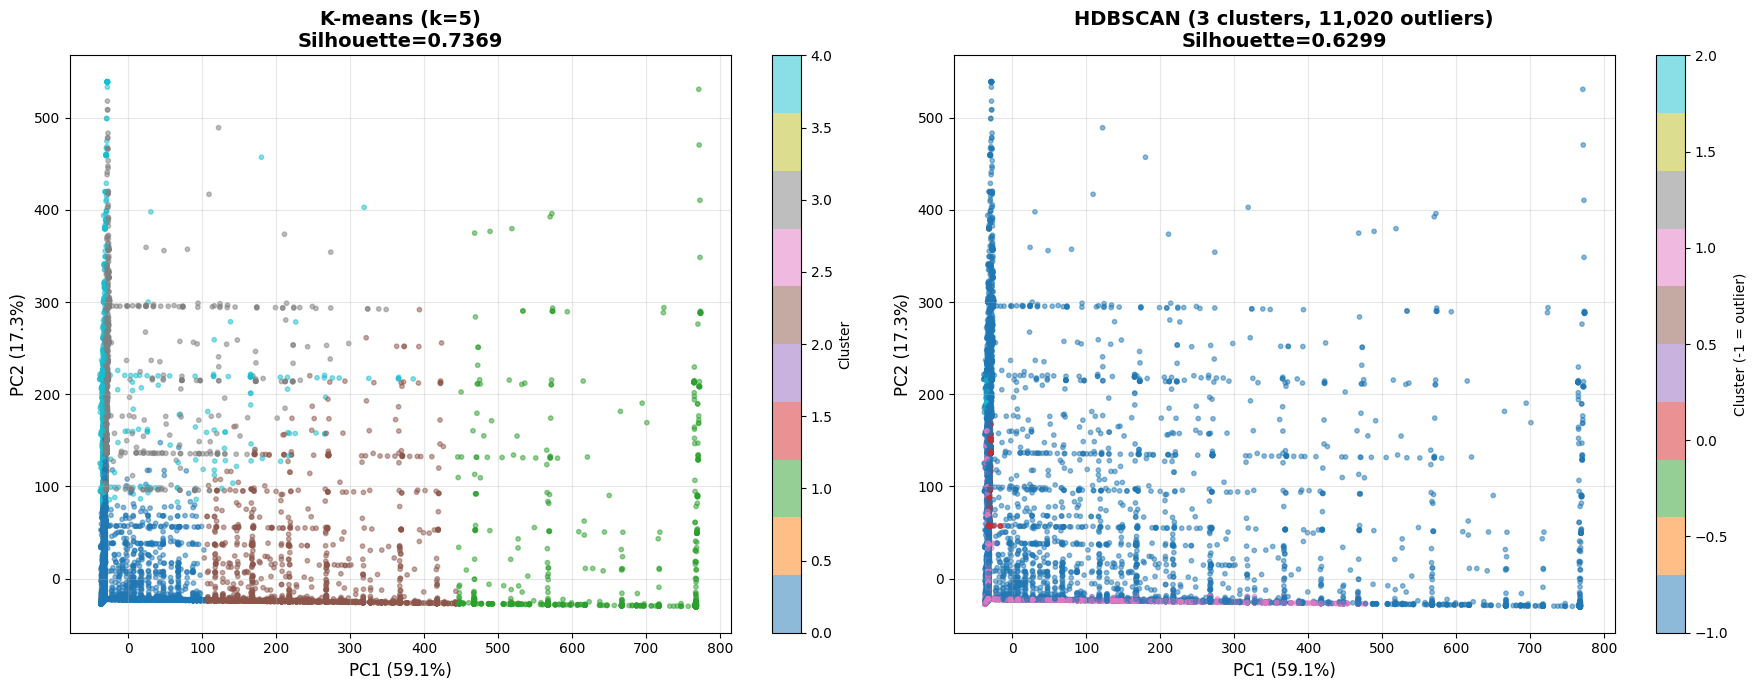

In [29]:
print("\n" + "="*80)
print("VISUALIZACIÓN CON PCA")
print("="*80)

print(f"\nReduciendo dimensionalidad con PCA...")

# PCA para visualización
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

print(f"PCA completado")
print(f"   Varianza explicada: {pca.explained_variance_ratio_.sum()*100:.2f}%")
print(f"   PC1: {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"   PC2: {pca.explained_variance_ratio_[1]*100:.2f}%")

# Visualizar K-means recomendado y HDBSCAN
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# K-means recomendado
ax1 = axes[0]
kmeans_labels_rec = df_kmeans[df_kmeans['k'] == k_recomendado].iloc[0]['labels']

scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], 
                       c=kmeans_labels_rec, 
                       cmap='tab10', 
                       alpha=0.5, 
                       s=10)
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
ax1.set_title(f'K-means (k={k_recomendado})\nSilhouette={kmeans_rec["silhouette"]:.4f}', 
              fontsize=14, fontweight='bold')
plt.colorbar(scatter1, ax=ax1, label='Cluster')
ax1.grid(True, alpha=0.3)

# HDBSCAN
ax2 = axes[1]
scatter2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], 
                       c=hdbscan_labels, 
                       cmap='tab10', 
                       alpha=0.5, 
                       s=10)
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
ax2.set_title(f'HDBSCAN ({n_clusters_hdbscan} clusters, {n_noise:,} outliers)\nSilhouette={silhouette_hdbscan:.4f}' if n_clusters_hdbscan > 1 else 'HDBSCAN', 
              fontsize=14, fontweight='bold')
plt.colorbar(scatter2, ax=ax2, label='Cluster (-1 = outlier)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/clustering_pca.png', dpi=150, bbox_inches='tight')
print(f"\nVisualización guardada: clustering_pca.png")
plt.show()


In [30]:
# Recomendación basada en métricas
if n_clusters_hdbscan > 1:
    if silhouette_hdbscan > kmeans_rec['silhouette'] and n_noise < len(X) * 0.05:
        modelo_recomendado = 'HDBSCAN'
        labels_final = hdbscan_labels
    else:
        modelo_recomendado = f'K-means (k={k_recomendado})'
        labels_final = kmeans_labels_rec
else:
    modelo_recomendado = f'K-means (k={k_recomendado})'
    labels_final = kmeans_labels_rec

print(f"\nMODELO RECOMENDADO: {modelo_recomendado}")


MODELO RECOMENDADO: K-means (k=5)


In [31]:
# Crear DataFrame con resultados
df_resultados = df_scaled.copy()
df_resultados[f'cluster_kmeans_k{k_recomendado}'] = kmeans_labels_rec
df_resultados['cluster_hdbscan'] = hdbscan_labels
df_resultados['cluster_final'] = labels_final

# Agregar coordenadas PCA para visualización futura
df_resultados['pca1'] = X_pca[:, 0]
df_resultados['pca2'] = X_pca[:, 1]

output_path = 'output/dataset_con_clusters.parquet'
df_resultados.to_parquet(output_path, compression='snappy', index=False)

print(f"\nResultados guardados:")
print(f"   {output_path}")
print(f"   {df_resultados.shape[0]:,} hogares × {df_resultados.shape[1]} columnas")

# Guardar también métricas
df_kmeans.to_csv('output/kmeans_metricas.csv', index=False)
df_comparacion.to_csv('output/comparacion_modelos.csv', index=False)

print(f"\nMétricas guardadas:")
print(f"   kmeans_metricas.csv")
print(f"   comparacion_modelos.csv")


# Guardar modelo K-means final
import pickle
modelo_final = df_kmeans[df_kmeans['k'] == k_recomendado].iloc[0]['model']
with open('output/modelo_kmeans_final.pkl', 'wb') as f:
    pickle.dump(modelo_final, f)

print(f"\n Modelo guardado:")
print(f"    modelo_kmeans_final.pkl")



Resultados guardados:
   output/dataset_con_clusters.parquet
   57,366 hogares × 173 columnas

Métricas guardadas:
   kmeans_metricas.csv
   comparacion_modelos.csv

 Modelo guardado:
    modelo_kmeans_final.pkl
